# (Project Title)
## Team Members: Altair Aguelo (A17435920), Ashton Bothun (A17388030), Gavin Guyal (), Jason Tang (A17438070)

# 1. Introduction & Predictive Task

## Dataset Description
Source: https://cseweb.ucsd.edu/~jmcauley/datasets.html#twitch <br>
Basic Properties <br>
> The raw data is Twitch metadata. The columns of the data include a Twitch user's ID, a stream ID, the streamer's username, time start, and time stop. Time start and time stop are in increments of 10 minutes, representing how long a user watches that specific stream/streamer. So, each row of data accounts for a specific Twitch user and an instance of them watching a stream. The full dataset has 15.5M data points. For the purposes of this project, we will be using the subset of 100k users in our model/training/exploration. <br>

## Predictive Task
> Our task we chose is to predict whether a user will watch a specific streamer. Models that would be appropriate for this task include logistic regression or latent factor models like factorization machines, temporal based latent factor models, and sequential recommendation models. Since our dataset includes users and "item consumption" through the streamers they watch, we can also form relevant user and item/streamer features. These features can be used to describe user behaviors/history, and in the inverse sense streamer metrics/history. Time is also an important feature that can be used to better map user behavior. This task is relevant to real life applications because a good model could be used to predict future user and streamer behavior. It would be a good way to help with possibly recommending users new streamers to watch or on the flip side help streamers grow as well as see what kind of audience they are reaching.

## Evaluation Metrics and Model Prediction Validity
> To evaluate our model, we will split our data into a training and test set. We will also need to create an evaluation file to predict on. This file will help us evaluate our model. Becuase our data is only made up of "positive" instances where the user watches a streamer, the evaluation file will be a mix of data from the test set and negative samples. Negative samples would be a user never watching a certain streamer. Evaluating in this way will allow us to measure the accuracy of our model, letting us view true positives, false positives, true negatives, and false negatives. It ensures our model is actually recommending smartly, and not just looking for positive/watched instances. 

## Possible Baselines
> The first baseline would be to predict the most popular streamer in our dataset. Just by getting the streamer username that comes up the most. If we use the most popular from our dataset then there will already be a minimum number that will be accurate since that streamer username already appears the most in our data. To beat the baseline our predictions would hopefully find other streamer usernames that would be tailored based on the similarities, latent factor, and other features of who they have watched rather than just the most popular.
> Another baseline would be a "model" that utilizes time. An interesting feature for prediction would be to predict that a user will watch a streamer if they have watched that streamer within the past 3 days. We could do this by doing a little bit of math in our dataset, calculating 3 days before a data point's start time for a user (based on increments of 10 minutes), and checking if the user watched the queried streamer in the past 3 days. This method would work in this dataset but for real life datasets would be a little bit more complicated and have to consider constantly updating databases/user data.


# 2. Exploratory Data Analysis and Pre-processing
## Ex data cleaning, visualizations, creating features, etc.

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import tarfile
import io

In [16]:
df = pd.read_csv("100k_a.zip", compression='zip', header=None, names=[
    "user_id",
    "streamID",
    "streamer_username",
    "time_start",
    "time_end"
])
df["duration"] = (df["time_end"].astype(int) - df["time_start"]).astype(int) * 10
print(df.head())

   user_id     streamID streamer_username  time_start  time_end  duration
0        1  33842865744          mithrain         154       156        20
1        1  33846768288             alptv         166       169        30
2        1  33886469056          mithrain         587       588        10
3        1  33887624992              wtcn         589       591        20
4        1  33890145056         jrokezftw         591       594        30


In [17]:
#Check for nulls
df.isnull().sum() / len(df) * 100

user_id              0.0
streamID             0.0
streamer_username    0.0
time_start           0.0
time_end             0.0
duration             0.0
dtype: float64

In [18]:
unique_user_counts = (
    df.groupby("streamer_username")["user_id"]
      .nunique()
      .sort_values(ascending=False)
)
print(unique_user_counts.head(10))

streamer_username
ninja           17154
tfue            14460
shroud          11011
riotgames        7747
sodapoppin       5982
nickmercs        5953
dakotaz          5939
fortnite         5721
timthetatman     5367
symfuhny         5263
Name: user_id, dtype: int64


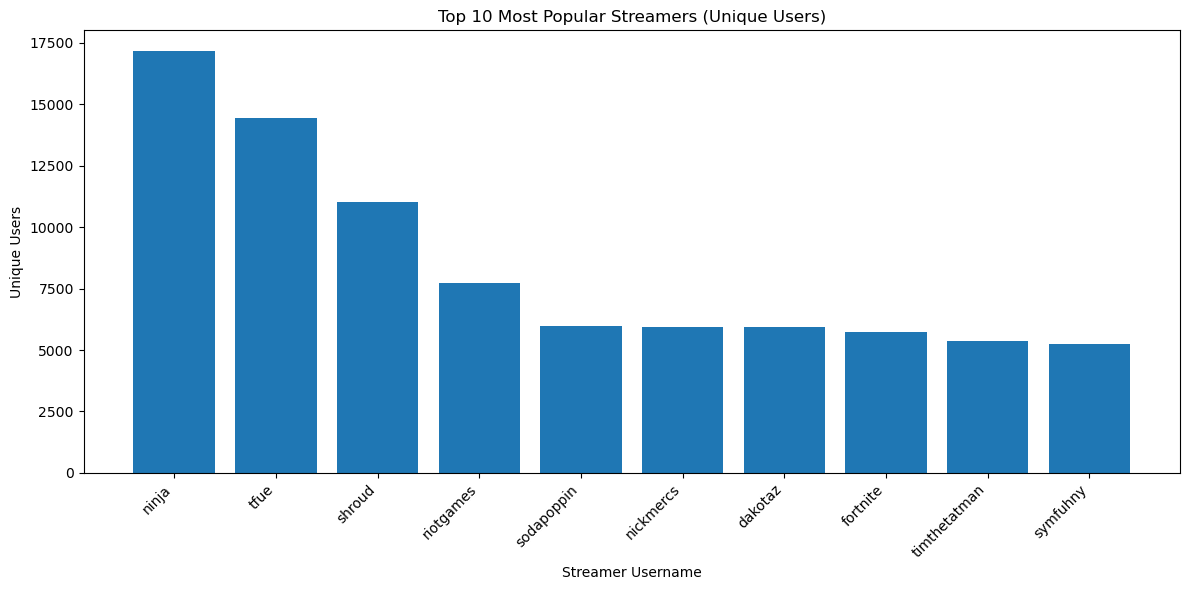

In [19]:
top10 = unique_user_counts.head(10)

plt.figure(figsize=(12, 6))
plt.bar(top10.index, top10.values)
plt.title("Top 10 Most Popular Streamers (Unique Users)")
plt.xlabel("Streamer Username")
plt.ylabel("Unique Users")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [20]:
# popularity in terms of straight views
most_watch_counts = (
    df.groupby("streamer_username")["user_id"]
      .count()
      .sort_values(ascending=False)
)
print(most_watch_counts.head(10))

streamer_username
ninja         45144
tfue          40136
shroud        27362
riotgames     17633
sodapoppin    14590
nickmercs     14047
dakotaz       13902
asmongold     13186
summit1g      13039
esl_csgo      12547
Name: user_id, dtype: int64


In [8]:
most_watched_by_time = (
    df.groupby("streamer_username")["duration"]
      .sum()
      .sort_values(ascending=False)
)
print(most_watched_by_time.head(10))

streamer_username
ninja         1114940
tfue          1066720
shroud         749340
riotgames      711480
asmongold      540700
sodapoppin     522600
dakotaz        430590
summit1g       427240
xqcow          407160
esl_csgo       394150
Name: duration, dtype: int32


# 3. Modeling

## Baseline Model

### Popular Streamer Model

In [ ]:
import pandas as pd
import random

# load data
# df = pd.read_csv("100k_a.zip", compression='zip', header=None, names=[
#     "user_id",
#     "streamID",
#     "streamer_username",
#     "time_start",
#     "time_end"
# ])
# df["duration"] = (df["time_end"].astype(int) - df["time_start"]).astype(int) * 10

# Sort by time to do a temporal split (Past -> Train, Future -> Test)
df = df.sort_values('time_start')

# Split: 80% Train, 20% Test
split_index = int(len(df) * 0.8)
train_df = df.iloc[:split_index]
test_df = df.iloc[split_index:]

print(f"Training on {len(train_df)} rows, Testing on {len(test_df)} rows")

# Get the top 10 most popular streamers from train set
top_10_streamers = train_df['streamer_username'].value_counts().head(10).index.tolist()

print("Top 10 Streamers:", top_10_streamers)

# Gen test pairs
# Half will be real watches (Ground Truth = 1, meaning watched), half will be random (Ground Truth = 0, meaning not watched)

# Helper: Create a dictionary of what users have already watched (to avoid bad negatives)
all_streamers = list(df['streamer_username'].unique())
user_watched_history = df.groupby('user_id')['streamer_username'].apply(set).to_dict()

test_pairs = []

for index, row in test_df.iterrows():
    user_id = row['user_id']
    streamer = row['streamer_username']
    
    # 1. Add the POSITIVE sample (Real Watch)
    test_pairs.append({
        'userID': user_id,
        'streamer_username': streamer,
        'ground_truth': 1
    })
    
    # 2. Add the NEGATIVE sample (Fake Watch)
    # Pick a random streamer this user has NEVER watched
    while True:
        random_streamer = random.choice(all_streamers)
        if random_streamer not in user_watched_history.get(user_id, set()):
            break
            
    test_pairs.append({
        'userID': user_id,
        'streamer_username': random_streamer,
        'ground_truth': 0
    })

# Convert to DataFrame
evaluation_df = pd.DataFrame(test_pairs)

# popular baseline model and predictions

def predict_popularity(streamer_name, top_list):
    """
    Returns 1 if streamer is in top list, 0 otherwise.
    """
    if streamer_name in top_list:
        return 1
    else:
        return 0

# Apply the function to the 'streamer_username' column
evaluation_df['prediction'] = evaluation_df['streamer_username'].apply(
    lambda x: predict_popularity(x, top_10_streamers)
)

# Check accuracy
correct_predictions = (evaluation_df['prediction'] == evaluation_df['ground_truth']).sum()
accuracy = correct_predictions / len(evaluation_df)
print(f"Baseline Model Accuracy: {accuracy:.4f}")

# Save to file for submission
# We usually drop 'ground_truth' for the submission file
output_df = evaluation_df[['userID', 'streamer_username', 'prediction']]
output_df.to_csv('popular_baseline_predictions.csv', index=False)

print("Predictions saved to 'baseline_predictions.csv'")

Training on 2441386 rows, Testing on 610347 rows
Top 10 Streamers: ['ninja', 'tfue', 'shroud', 'riotgames', 'esl_csgo', 'dakotaz', 'sodapoppin', 'asmongold', 'summit1g', 'nickmercs']
Baseline Model Accuracy: 0.5334
Predictions saved to 'baseline_predictions.csv'


### Recently Watched Model

In [26]:
import pandas as pd
import random

# ==========================================
# 1. SETUP AND LOOKUP TABLE
# ==========================================
# We need a fast way to check "Did User U watch Streamer S at Time T?"
# Grouping by User is the most efficient way.

df = pd.read_csv("100k_a.zip", compression='zip', header=None, names=[
    "user_id",
    "streamID",
    "streamer_username",
    "time_start",
    "time_end"
])
df["duration"] = (df["time_end"].astype(int) - df["time_start"]).astype(int) * 10

df = df.sort_values('time_start')

# Split Train/Test (80/20)
split_idx = int(len(df) * 0.8)
train_df = df.iloc[:split_idx]
test_df = df.iloc[split_idx:]

print("Building history lookup...")
# Create a dictionary: { user_id: [(time, streamer), (time, streamer)...] }
# We use the FULL dataset for history lookups, but we will filter by time later
# to ensure we don't "cheat" (peek into the future).
user_history = df.groupby('user_id').apply(
    lambda x: list(zip(x['time_start'], x['streamer_username']))
).to_dict()

# ==========================================
# 2. GENERATE TIME-AWARE TEST SET
# ==========================================
# We need pairs (User, Streamer, Time) to test on.
all_streamers = list(df['streamer_username'].unique())
test_pairs = []

print("Generating test pairs...")
for _, row in test_df.iterrows():
    u_id = row['user_id']
    t_start = row['time_start']
    real_streamer = row['streamer_username']
    
    # 1. Positive Sample (Real Watch)
    test_pairs.append({
        'user_id': u_id,
        'streamer_username': real_streamer,
        'time_start': t_start,
        'ground_truth': 1
    })
    
    # 2. Negative Sample (Random Streamer)
    # We assign the SAME timestamp. "At this moment, would they watch this random person?"
    while True:
        rand_streamer = random.choice(all_streamers)
        # Simple check to ensure it's not the one they actually watched right now
        if rand_streamer != real_streamer:
            break
            
    test_pairs.append({
        'user_id': u_id,
        'streamer_username': rand_streamer,
        'time_start': t_start,
        'ground_truth': 0
    })

eval_df = pd.DataFrame(test_pairs)

# ==========================================
# 3. APPLY THE "3-DAY WINDOW" MODEL
# ==========================================
WINDOW_SIZE = 432  # 3 days * 144 units/day

def predict_recent_watch(user, streamer, current_time):
    """
    Returns 1 if user watched streamer in [current_time - 432, current_time).
    Returns 0 otherwise.
    """
    history = user_history.get(user, [])
    
    # Look through history
    for (past_time, past_streamer) in history:
        # STOP if we hit the future (cheating check)
        if past_time >= current_time:
            break
            
        # Check if it's within the window
        if past_time >= (current_time - WINDOW_SIZE):
            if past_streamer == streamer:
                return 1
                
    return 0

print("Running predictions...")
# This might take a moment depending on dataset size
eval_df['prediction'] = eval_df.apply(
    lambda row: predict_recent_watch(row['user_id'], row['streamer_username'], row['time_start']),
    axis=1
)

# ==========================================
# 4. EVALUATE AND SAVE
# ==========================================
from sklearn.metrics import accuracy_score

acc = accuracy_score(eval_df['ground_truth'], eval_df['prediction'])
print(f"3-Day Repeat Model Accuracy: {acc:.4f}")

# Save to file
eval_df[['user_id', 'streamer_username', 'time_start', 'prediction']].to_csv('time_baseline_predictions.csv', index=False)
print("Saved to 'time_baseline_predictions.csv'")

Building history lookup...


C:\Users\altai\AppData\Local\Temp\ipykernel_17840\2382347857.py:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  user_history = df.groupby('user_id').apply(


Generating test pairs...
Running predictions...
3-Day Repeat Model Accuracy: 0.6193
Saved to 'time_baseline_predictions.csv'


## Our Model

## Training (train/test split and evalation metric like acc AUC, MSE, precision...)

# 4. Evaluation

# 5. Related Work